In [102]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

## Downloading the data

In [103]:
df = pd.read_parquet('https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet')
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,NaN,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,NaN,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,NaN,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,NaN,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,NaN,B00037


In [104]:
df.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                          float64
Affiliated_base_number            object
dtype: object

In [106]:
df.shape

(1154112, 7)

## Computing duration

In [107]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,NaN,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,NaN,B00009,17.000000
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,NaN,B00013,110.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,NaN,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,NaN,B00037,15.216667


In [108]:
print(f"The average trip duration in January is: %{df.duration.mean():.3f}")

The average trip duration in January is: %19.167


## Data preparation

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

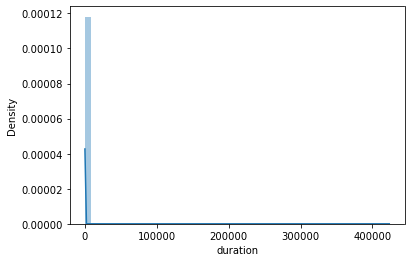

In [78]:
sns.distplot(df['duration'])


In [79]:
df['duration'].sort_values(ascending=False)

345570     423371.050000
1153556     40347.600000
457454      26017.133333
10288       17322.000000
230325      14314.000000
               ...      
479151          0.016667
479162          0.016667
861255          0.016667
1005805         0.016667
38559           0.016667
Name: duration, Length: 1154112, dtype: float64

## Remove outliers
keep only the records where the duration was between 1 and 60 minutes (inclusive)

In [80]:
df = df[(df.duration >= 1) & (df.duration <= 60)]
df.shape

(1109826, 8)

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

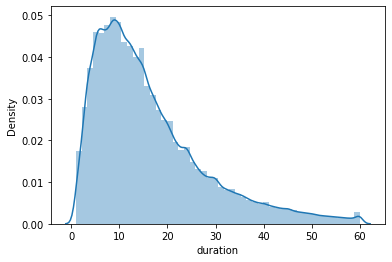

In [81]:
sns.distplot(df['duration'])

<AxesSubplot:xlabel='duration'>

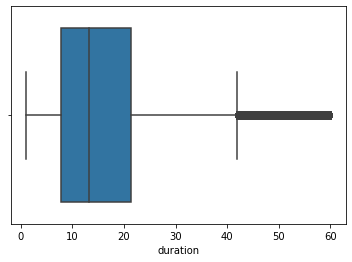

In [82]:
sns.boxplot(x = df['duration'], orient='horizontal')

In [83]:
#print(f"Percentage of missing values: % {(df['PUlocationID'].isna().sum() / len(df))*100:.2f}")

## Missing values

In [84]:
df['PUlocationID'].fillna(value=-1, inplace=True)
df['DOlocationID'].fillna(value=-1, inplace=True)

In [85]:
print(f"Percentage of missing values is: {(df['PUlocationID'].eq(-1).mean())*100:.2f} %")

Percentage of missing values is: 83.53 %


## One-hot encoding

### Turn the dataframe into a list of dictionaries

In [86]:
categorical = ['PUlocationID', 'DOlocationID']
df[categorical] = df[categorical].astype(str)
df['PU_DO'] = df['PUlocationID'] + '_' + df['DOlocationID']
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration,PU_DO
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,-1.0,-1.0,NaN,B00009,17.000000,-1.0_-1.0
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,-1.0,-1.0,NaN,B00009,17.000000,-1.0_-1.0
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,-1.0,72.0,NaN,B00037,8.283333,-1.0_72.0
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,-1.0,61.0,NaN,B00037,15.216667,-1.0_61.0
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,-1.0,71.0,NaN,B00037,9.050000,-1.0_71.0


In [87]:

train_dicts = df[categorical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [88]:
#X_train.shape[1]
print(len(dv.feature_names_))

525


### Training a model

- Train a plain linear regression model with default parameters

In [89]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

- Calculate the RMSE of the model on the training data

In [90]:
y_pred = lr.predict(X_train)
rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f'RMSE on training data is {rmse:.2f}')


RMSE on training data is 10.53


/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


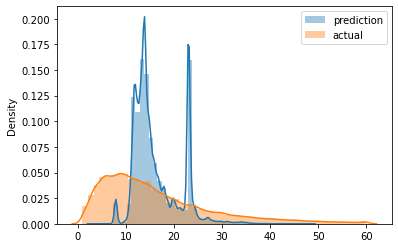

In [91]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

## Evaluating the model

In [92]:
def read_dataframe(filename, categorical):
    # Downloading the data
    df = pd.read_parquet(filename)

    # Computing duration
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    # Remove outliers
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    # Handel missing values
    df['PUlocationID'].fillna(value=-1, inplace=True)
    df['DOlocationID'].fillna(value=-1, inplace=True)

    # 
    df[categorical] = df[categorical].astype(str)

    return df



In [93]:
categorical = ['PUlocationID', 'DOlocationID']
file_url = 'https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet'

df_val = read_dataframe(file_url, categorical)
len(df_val)

990113

In [94]:
df_val.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
1,B00021,2021-02-01 00:55:40,2021-02-01 01:06:20,173.0,82.0,NaN,B00021,10.666667
2,B00021,2021-02-01 00:14:03,2021-02-01 00:28:37,173.0,56.0,NaN,B00021,14.566667
3,B00021,2021-02-01 00:27:48,2021-02-01 00:35:45,82.0,129.0,NaN,B00021,7.950000
4,B00037,2021-02-01 00:12:50,2021-02-01 00:26:38,-1.0,225.0,NaN,B00037,13.800000
5,B00037,2021-02-01 00:00:37,2021-02-01 00:09:35,-1.0,61.0,NaN,B00037,8.966667


In [95]:
val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [101]:
y_val = df_val[target].values
y_pred = lr.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f'RMSE {rmse:.2f}')

RMSE 11.30


In [99]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)